# CNN for Classification of Quantum Measurements
Thanks to Théau Peronnin for providing the original code and the original data [arXiv:1904.04635].

In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
hdf = h5py.File(r"datasets/example_data_very_short.h5", "r")
data = np.array(hdf["data_tensor"])
print(data.shape)
[np.mean(data), np.var(data), np.std(data)]

(200000, 2, 100)


[-0.0028620095, 0.0026083235, 0.05107175]

In [2]:
d_transform = data
d_transform.shape

(200000, 2, 100)

## Visualisation of the Traces V(t)

0 99
0.0 1.0


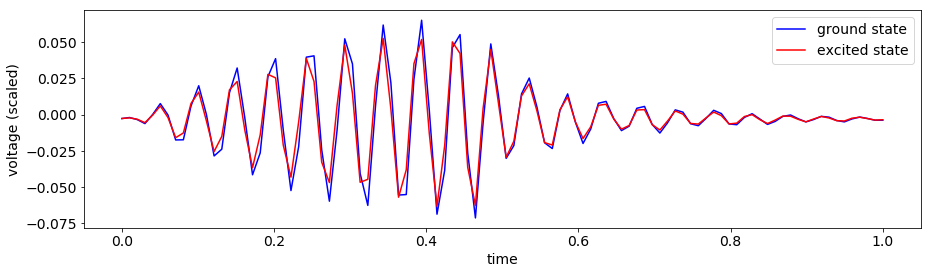

(2, 100)

In [3]:
d_av = np.mean(d_transform, axis=0)
t = np.array(range(len(d_transform[0, 0])))
print(t[0], t[-1])
xf = np.arange(len(t))*1./t[-1]
print(xf[0], xf[-1])
# plot average signals
plt.figure(figsize=(15,4))
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.xlabel("time", fontsize=14)
plt.ylabel("voltage (scaled)", fontsize=14)
plt.plot(xf, d_av[0], "b-", label="ground state")
plt.plot(xf, d_av[1], "r-", label="excited state")
plt.legend(loc="best", fontsize=14)
plt.show()
d_av.shape

## Demodulation (for a given set of parameters)


In [4]:
d = d_transform
#Construction of the demodulation weight function w(t) = x + iy 
x = (d_av[1]-d_av[0])/2.
y = np.real(np.fft.irfft(np.fft.rfft(x, axis = -1)*1j,x.shape[0], axis = -1)) 
#Normalazing : actual axis not calibrated for this experiment
x = x/np.sqrt(np.sum(x**2))
y = y/np.sqrt(np.sum(y**2))
#Demodulation
dIQ = d*(x+1j*y)
dint = np.average(dIQ,axis = -1)
dint = dint.T
dint.shape

(2, 200000)

In [5]:
# Histogram functions
a = np.amax(np.abs(dint)) #fixing the range
r = [[-a,a],[-a,a]]
def hist(dint,ge):
    h = np.histogram2d(np.real(dint[ge]),np.imag(dint[ge]), bins = 50, normed = False, range = r)[0]
    return h    
def ol(dint): # 2d scalar product
    Pg = hist(dint,0)
    Pe = hist(dint,1)
    o = np.sum(Pg*Pe)/(np.sqrt(np.sum(Pg**2))*np.sqrt(np.sum(Pe**2)))
    return o
print("Overlap : "+str(ol(dint)*100) +"%")
def Z(data,ge): #Defining the zone associated with either g or e
    z = hist(data,ge) >  hist(data,1-ge)
    z = z + (hist(data,ge) ==  hist(data,1-ge))*0.5
    return z
def ol_z(data,ge): #Computation of the error
    o = np.sum(Z(data,ge)*hist(data,ge))/np.sum(hist(data,ge))
    return o
print("Error by zone, g: "+str((1-ol_z(dint,0))*100) +"%, e: "+str((1-ol_z(dint,1))*100) +"%")
fidelity = ((ol_z(dint,0)) + (ol_z(dint,1)))/2 * 100
print("Fidelity: " + str(fidelity) + "%" )

Overlap : 90.6024849955735%
Error by zone, g: 16.509249999999998%, e: 53.92675%
Fidelity: 64.78200000000001%


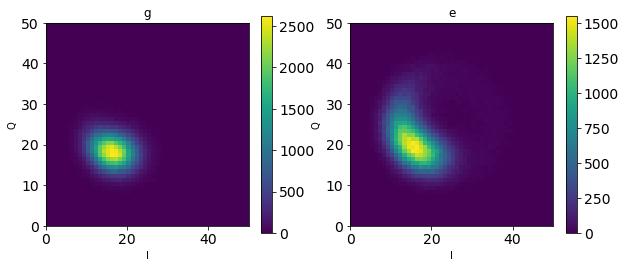

In [6]:
# make plot with 2 subplots
fig, ax = plt.subplots(1,2, figsize=(10, 4))
# subplot 1
plot = ax[0].pcolormesh(hist(dint,0)) # histogram for ground state
fig.colorbar(plot,ax=ax[0],orientation="vertical")
ax[0].set_xlabel("I") # Re[\beta], see Eq. (2)
ax[0].set_ylabel("Q") # Im[\beta], see Eq. (2)
ax[0].set_title("g")  # ground state label
ax[0].axis("tight")   # save space
ax[0].set_aspect(1)   # aspect ratio
# subplot 2
plot = ax[1].pcolormesh(hist(dint,1)) # histogram for excited state; as above
fig.colorbar(plot,ax=ax[1],orientation="vertical")
ax[1].set_xlabel("I") # Re[\beta], see Eq. (2)
ax[1].set_ylabel("Q") # Im[\beta], see Eq. (2)
ax[1].set_title("e")  # excited state label
ax[1].axis("tight")   # save space
ax[1].set_aspect(1)
# show all subplots
plt.show()

## Dataset Preparation

In [7]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
print(d_g.shape)
d_g[0:3, 0:2]

(200000, 101)


array([[ 0.        , -0.00947497],
       [ 0.        ,  0.07355312],
       [ 0.        , -0.01357753]])

In [8]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
d_e = d_transform[:, 1, :]                           # excited state features
class_e = np.array([[1 for i in range(len(d_e))]]).T # excited state labels
d_e = np.concatenate((class_e, d_e), axis=1)         # excited state features, labels
ge_data = np.concatenate((d_g, d_e), axis=0)         # ground and excited state labels, features
print(ge_data.shape)                                 # instances, label + features
# for np.random.seed, see https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do/21494630
np.random.seed(0)
shuffle_index = np.random.permutation(len(ge_data))  # create a random order (via indices)
print(shuffle_index[:5])                             # show a few randomized indices
first_5_pseudo_random = np.array([242160, 3413, 393024, 247987, 52436])
print(np.linalg.norm(first_5_pseudo_random - shuffle_index[:5]) == 0)
ge_shuffle_data = ge_data[shuffle_index]             # apply the random order
X_data = ge_shuffle_data[:, 1:]                      # select the features ...
Y_data = ge_shuffle_data[:, :1]                      # ... and the labels
print(X_data.shape)    # shape of feature data
print(Y_data.shape)    # shape of label data
print(X_data[:10, :5]) # for the first 10 instances, show the first 5 features, ...
Y_data[:10]            # ... and the according label

(400000, 101)
[242160   3413 393024 247987  52436]
True
(400000, 100)
(400000, 1)
[[ 0.04385836  0.07316239  0.01162393 -0.03096459 -0.0034188 ]
 [ 0.02803419 -0.05655678 -0.09797314 -0.01494506  0.06398047]
 [ 0.02119658  0.02393162  0.04424908 -0.0157265  -0.07238095]
 [-0.05870574  0.05714286  0.00986569  0.00673993  0.03350427]
 [-0.04229548 -0.04678877  0.01924298 -0.02295482 -0.04678877]
 [-0.02881563 -0.05245421  0.03096459  0.0790232   0.00908425]
 [-0.04327228 -0.00830281  0.00771673 -0.01494506  0.02764347]
 [-0.00283272 -0.01221001  0.01103785  0.03838828  0.0206105 ]
 [-0.0254945  -0.01885226  0.01025641  0.04815629 -0.03428571]
 [-0.04444445 -0.00576313  0.05323565  0.00634921 -0.01943834]]


array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [9]:
print(len(Y_data))
split1 = int(0.8 * len(Y_data))
split2 = int(0.8 * split1)
# use test data for evaluation of the final (!) model (after development)
X_test, Y_test = X_data[split1:], Y_data[split1:]
print(X_test.shape, Y_test.shape)
# use validation data for early stopping and evaluation of different models (during development)
X_valid, Y_valid = X_data[split2:split1], Y_data[split2:split1]
print(X_valid.shape, Y_valid.shape)
# use training data for training / fitting different models (during development)
X_train, Y_train = X_data[:split2], Y_data[:split2]
print(X_train.shape, Y_train.shape)

400000
(80000, 100) (80000, 1)
(64000, 100) (64000, 1)
(256000, 100) (256000, 1)


-5.458422654464655 5.3484009034026885 3.630429290524262e-18 0.999999999999999
(256000, 100)


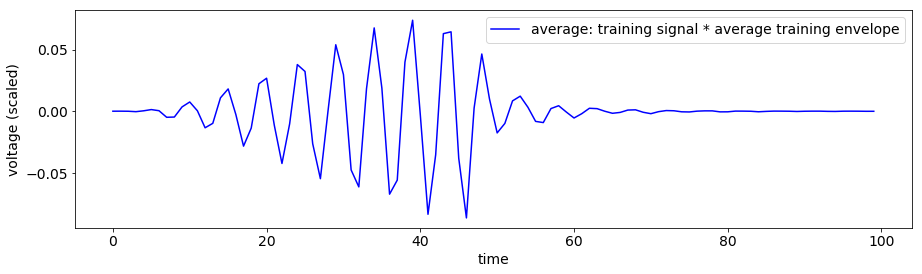

In [10]:
def preprocessing(X_input, scaling=True):
    if scaling:  # important: always use "X_train" on rhs since X_valid and X_test are "unknown"
        X_input = (X_input - np.mean(X_train)) / np.std(X_train)
    print(np.min(X_input), np.max(X_input), np.mean(X_input), np.std(X_input))
    env = np.abs(hilbert(np.mean(X_train, axis=0))) # envelope of training data average
    out = X_input * env
    print(out.shape)
    return out
xf = range(100)
plt.figure(figsize=(15,4))
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.xlabel("time", fontsize=14)
plt.ylabel("voltage (scaled)", fontsize=14)
plt.plot(xf, np.mean(preprocessing(X_train), axis=0), # use "preprocessing" function for y-axis data
         "b-", label="average: training signal * average training envelope")
plt.legend(loc="best", fontsize=14)
plt.show()

In [11]:
x_train = preprocessing(X_train)
y_train = Y_train
x_valid = preprocessing(X_valid)
y_valid = Y_valid
x_test = preprocessing(X_test)
y_test = Y_test
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)
x_shape = x_train.shape
if len(x_shape)==2:
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
    x_test  = np.reshape(x_test , (x_test.shape[0] , x_test.shape[1] , 1))
features_per_timestep = len(x_train[0, 0])
features_per_timestep

-5.458422654464655 5.3484009034026885 3.630429290524262e-18 0.999999999999999
(256000, 100)
-4.857831310206457 5.1609550076653115 -0.0005352784801271473 1.0001739235561133
(64000, 100)
-5.649693857549547 5.336924397789229 -0.0001513772947679686 1.0001421740594236
(80000, 100)
(256000, 100) (64000, 100) (80000, 100)
(256000, 1) (64000, 1) (80000, 1)


1

## Keras CNN
Using a simple Convolutional Neural Network – built with the *Keras Sequential* model – to classify the qubit eigenstates.

In [12]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import  Conv1D, Dense, Dropout, Flatten, ELU
from keras.layers.normalization import BatchNormalization
seq_length = 100
#del model
l2_reg = 0.01
drop_rate = 0.3
model = Sequential()
# layer 1
model.add(Dropout(drop_rate,
                  input_shape=(seq_length, features_per_timestep)))
model.add(Conv1D(40, 6, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
# layer 2
model.add(Dropout(drop_rate))
model.add(Conv1D(40, 6, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
# layer 3
model.add(Dropout(drop_rate))
model.add(Conv1D(40, 6, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
# layer 4
model.add(Dropout(drop_rate))
model.add(Conv1D(40, 6, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
# layer 5
model.add(Dropout(drop_rate))
model.add(Conv1D(80, 6, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Flatten())
# layer 6
model.add(Dense(units=20, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(BatchNormalization())
model.add(ELU(alpha=1.0))
# layer 7
model.add(Dropout(drop_rate))
model.add(Dense(units=1, activation='sigmoid',
                kernel_regularizer=regularizers.l2(l2_reg)))
# compile
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.inputs)
model.summary()

Using TensorFlow backend.


[<tf.Tensor 'dropout_1_input:0' shape=(?, 100, 1) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 95, 40)            280       
_________________________________________________________________
batch_normalization_1 (Batch (None, 95, 40)            160       
_________________________________________________________________
elu_1 (ELU)                  (None, 95, 40)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 95, 40)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 40)            9640      
_________________________________________________________________
batch_norm

In [13]:
max_score = 0
overfit_count_threshold = 25
for iteration in range(200):
    print(iteration)
    model.fit(x_train, y_train, epochs=1, batch_size=128)
    score = model.evaluate(x_valid, y_valid)
    if score[1] > max_score:
        best_model = model
        best_iteration = iteration
        max_score = score[1]
        test_score = model.evaluate(x_test, y_test)
        overfit_count = 0
    else:
        overfit_count += 1
    print(score, overfit_count)
    print("best iteration:\t", best_iteration, "\n")
    if overfit_count is overfit_count_threshold:
        break
print("Score of best model on test set:\t", test_score)

0
Epoch 1/1
80000/80000 [==============================] - 4s 49us/step
[0.6223958999365569, 0.6565] 0
best iteration:	 0 

1
Epoch 1/1
64000/64000 [==============================] - 3s 49us/step
[0.6345166813433171, 0.644546875] 1
best iteration:	 0 

2
Epoch 1/1
80000/80000 [==============================] - 4s 49us/step
[0.6228820544630289, 0.66659375] 0
best iteration:	 2 

3
Epoch 1/1
64000/64000 [==============================] - 3s 49us/step
[0.7320124165415763, 0.570796875] 1
best iteration:	 2 

4
Epoch 1/1
64000/64000 [==============================] - 3s 49us/step
[0.6922744459658862, 0.5805] 2
best iteration:	 2 

5
Epoch 1/1
64000/64000 [==============================] - 3s 45us/step
[0.6280098945647478, 0.65309375] 3
best iteration:	 2 

6
Epoch 1/1
64000/64000 [==============================] - 3s 47us/step
[0.621764464378357, 0.653921875] 4
best iteration:	 2 

7
Epoch 1/1
64000/64000 [==============================] - 3s 46us/step
[0.6216878419667482, 0.657640625] 5
be

64000/64000 [==============================] - 3s 44us/step
[0.6212971397936344, 0.660703125] 6
best iteration:	 29 

36
Epoch 1/1
64000/64000 [==============================] - 3s 44us/step
[0.6716732916384935, 0.59290625] 7
best iteration:	 29 

37
Epoch 1/1
64000/64000 [==============================] - 3s 44us/step
[0.6414341445565224, 0.62659375] 8
best iteration:	 29 

38
Epoch 1/1
64000/64000 [==============================] - 3s 44us/step
[0.6570987926721573, 0.611671875] 9
best iteration:	 29 

39
Epoch 1/1
64000/64000 [==============================] - 3s 45us/step
[0.6176373999416828, 0.664171875] 10
best iteration:	 29 

40
Epoch 1/1
64000/64000 [==============================] - 3s 44us/step
[0.6159364701360464, 0.66609375] 11
best iteration:	 29 

41
Epoch 1/1
64000/64000 [==============================] - 3s 44us/step
[0.6195059431791305, 0.66159375] 12
best iteration:	 29 

42
Epoch 1/1
64000/64000 [==============================] - 3s 44us/step
[0.6437013338059187, 0.6

The final result (66.9%) is more than 2% better than the one that has been found via the histogram functions (<64.8%, see further above).